In [1]:
!pip install einops



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


--2024-09-20 12:17:58--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.158.245.28, 108.158.245.9, 108.158.245.84, ...
Connecting to segment-anything.com (segment-anything.com)|108.158.245.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   255KB/s    in 0.8s    

2024-09-20 12:18:01 (255 KB/s) - ‘dog.jpg’ saved [221810/221810]

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

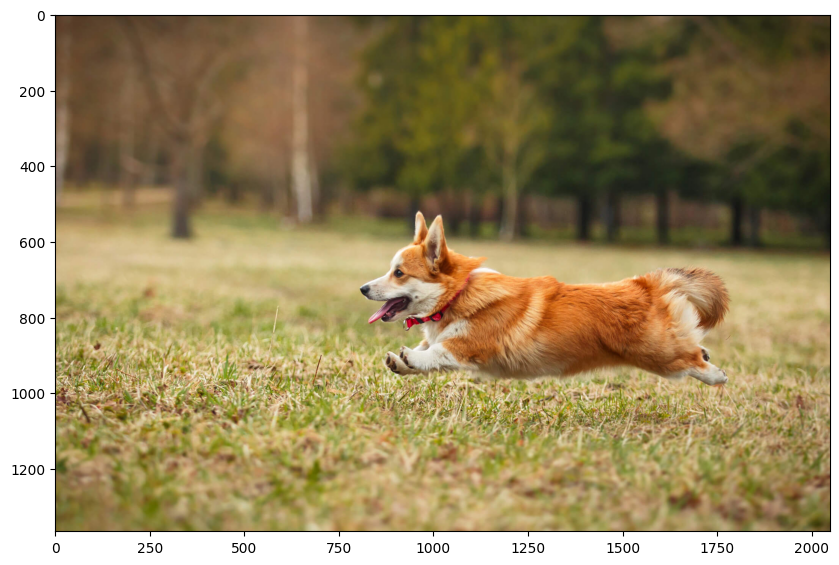

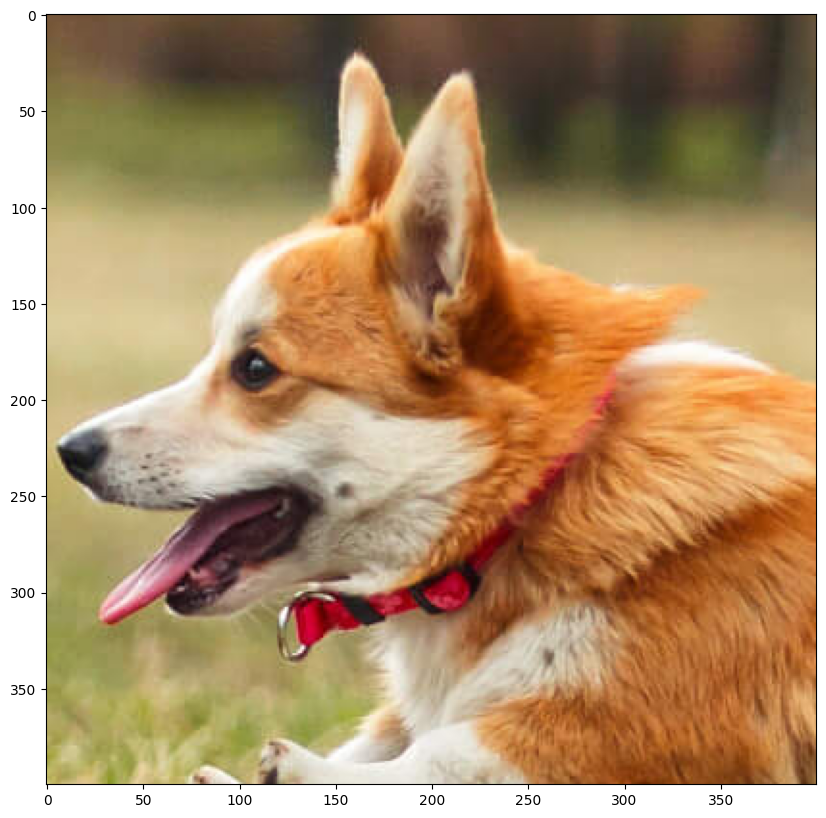

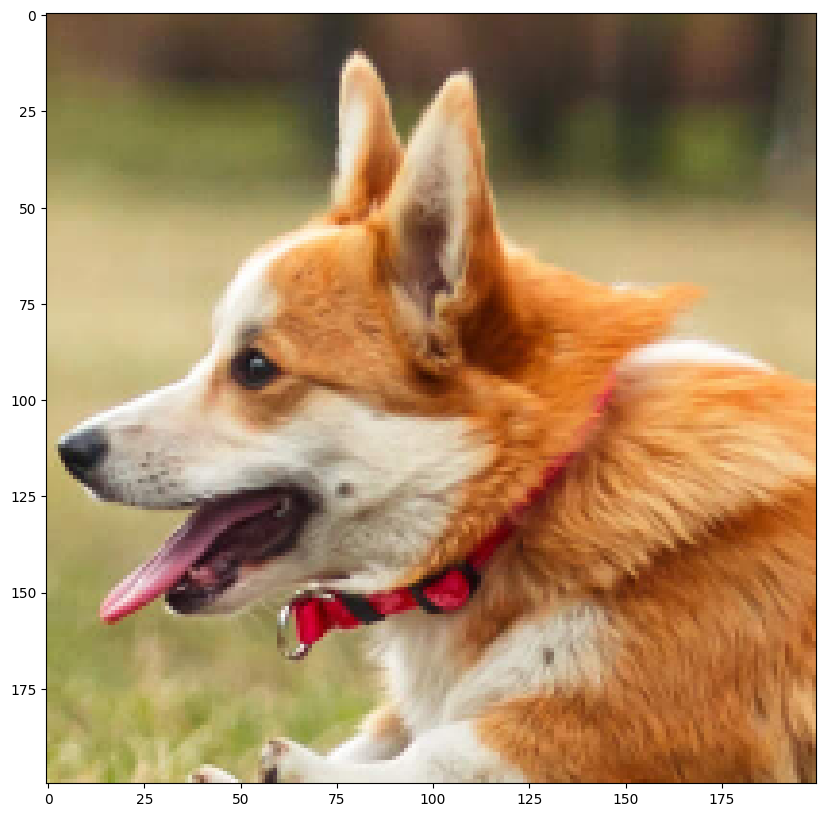

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from einops import rearrange
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Scale the dimensions of the image
    height = int(height * scale)
    width = int(width * scale)

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff


# Importing the image
from sklearn import preprocessing

dog = torchvision.io.read_image("./dog.jpg")

plt.figure(figsize=(10, 10))
plt.imshow(rearrange(dog, 'c h w -> h w c').numpy())

scaler = preprocessing.MinMaxScaler().fit(dog.reshape(-1, 1))

scaled_dog = scaler.transform(dog.reshape(-1, 1)).reshape(dog.shape)
scaled_dog = torch.tensor(scaled_dog).float().to(device)
print(scaled_dog.shape)
print(scaled_dog)
print(scaled_dog.max(), scaled_dog.min())


dog_400 = transforms.functional.crop(scaled_dog.cpu(), 500, 800, 400, 400)
#dog_400.shape

# dog_400

plt.figure(figsize=(10, 10))
plt.imshow(rearrange(dog_400, 'c h w -> h w c').cpu().numpy())



# Resizing the 400x400 to a 200x200 image

import cv2

dog_200 = rearrange(dog_400, 'c h w -> h w c').numpy()
dog_200 = cv2.resize(dog_200, (int(dog_200.shape[1]*0.5), int(dog_200.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
print(dog_200.shape)
plt.figure(figsize=(10, 10))
plt.imshow(dog_200)



# Converting the 200x200 back to a torch.Tensor object
dog_200 = torch.tensor(dog_200, dtype=torch.float16).permute(2,0,1).to(device)
print(dog_200.shape)
print(dog_200.min(), dog_200.max())
dog_200

import gc

gc.collect()



# Creating the Coordinate Map of the 200x200 image
X, Y = create_coordinate_map(dog_200)
print("Shape of X =", X.shape, "\nShape of Y =", Y.shape)
print("X:\n", X, "\nY:\n", Y)


# Scaling X using Min-Max Scaler
scaler = preprocessing.MinMaxScaler().fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)
print(scaled_X.shape)
print(scaled_X)

# Creating Random Fouruer Features (RFF) of the 200x200 scaled_X

X_rff, rff = create_rff_features(scaled_X, 37000, 0.01)
X_rff.shape

# Training the Linear Model on the Random Fourier Features

net = LinearModel(X_rff.shape[1], 3).to(device)
net

Y = Y.view(-1, 3)  # Reshape Y to (40000, 3)


Y = Y.to(device)
train(net, 0.02, X_rff, Y, 700)

import gc
del X_rff, X, Y, scaled_X
gc.collect()

# Creating the Coordinate Map for the Super-Resolution Image (2x Scaled: 400 x 400)

X_2, Y_2 = create_coordinate_map(dog_200, scale = 2)
print("Shape of X_2 =", X_2.shape, "\nShape of Y_2 =", Y_2.shape)
print("X_2:\n", X_2,"\nY_2:\n", Y_2)


# Scaling X using Min-Max Scaler

scaler = preprocessing.MinMaxScaler().fit(X_2.cpu())
scaled_X_2 = torch.tensor(scaler.transform(X_2.cpu())).float().to(device)
print(scaled_X_2.shape)
print(scaled_X_2)


# Transforming the scaled_X to the Random Fourier Features

X_rff = rff.transform(scaled_X_2.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)
print(X_rff.shape)
print(X_rff)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09087382..1.0550491].


torch.Size([160000, 3])


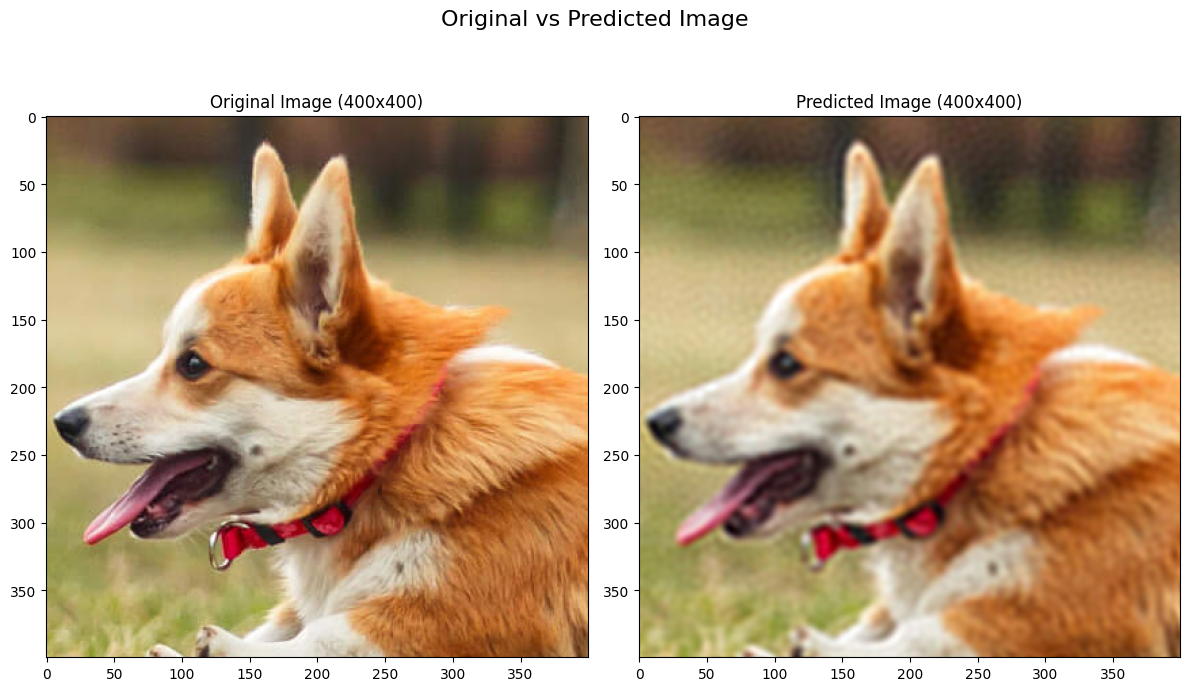

In [3]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    if(return_Output == 1):
        return pred_img
Y = plot_Original_vs_Predicted_Img(dog_400, X_rff, net, return_Output = 1)


In [4]:
Y = Y.to(device)
dog_400 = dog_400.to(device)

# Compute MSE
mse_loss = nn.MSELoss()
mse = mse_loss(Y, dog_400)

# Compute PSNR
def psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0:  # Means no noise in the image
        return 100
    pixel_max = 1.0  # Assuming pixel values are normalized between 0 and 1
    return 20 * np.log10(pixel_max / np.sqrt(mse))
psnr_value = psnr(dog_400.cpu().flatten().detach().numpy(), Y.cpu().flatten().detach().numpy())

print(f"RMSE: {mse.item()**0.5:.6f}")
print(f"PSNR: {psnr_value:.6f} dB")

RMSE: 0.030677
PSNR: 30.263710 dB
